# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 
***
**Advanced Lane Finding Project**

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Camera Calibration

Determining the camera calibration matrix and distortion coefficients is the first step toward correcting distortion in images. To obtain these we use a set of chessboard images and OpenCV's `calibrateCamera()` and `findChessboardCorners()` functions. Chessboard corners are detected in each image using `findChessboardCorners()` and are stored in the `img_points` array. For each set of `img_points` found a corresponding set of 3D points representing the position of the corner in the world coordinate space is kept in `obj_points`. These `obj_points` and `img_points` are then fed to `calibrateCamera()` to obtain our calibration matrix and distortion coefficients. Given an image, the matrix, and the distortion coefficients, OpenCV's `undistort()` can then be used to correct for distortion on any image taken with that camera and lens.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import project_data
import camera
%matplotlib inline

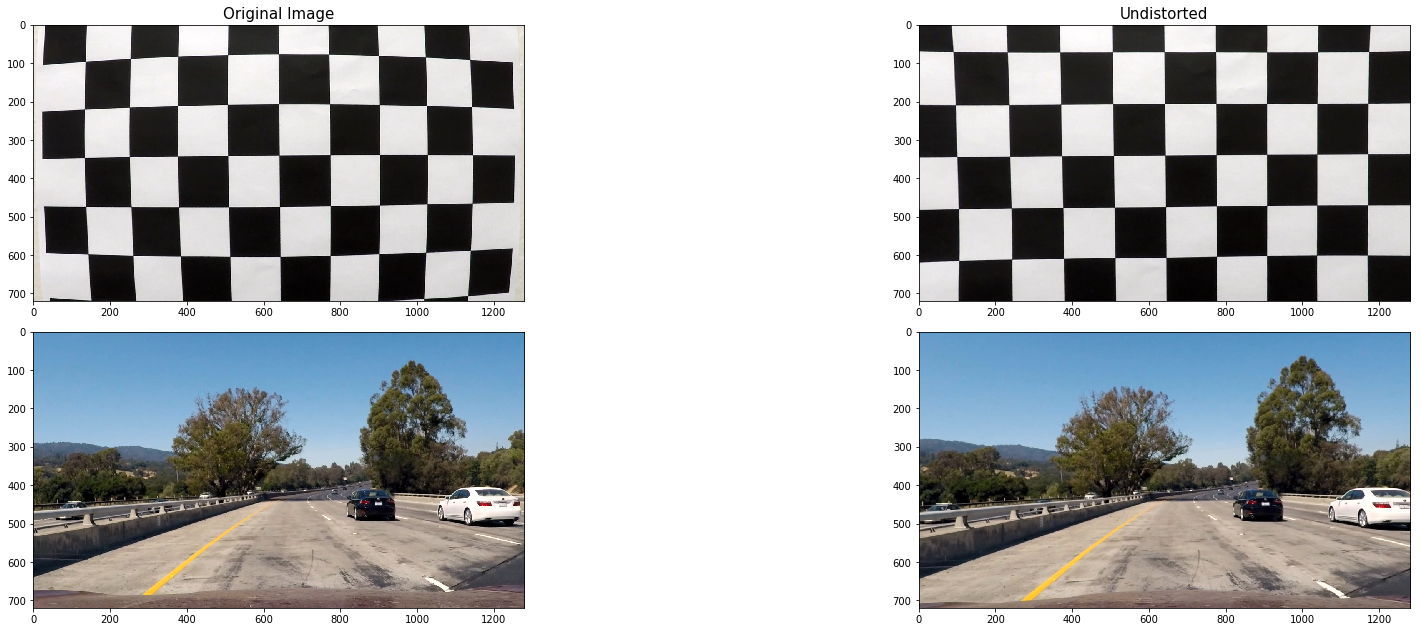

In [2]:
#
# Read in images
# calibration1.jpg is a chessboard. test3.jpg is an
# image of a road.  
img1 = cv2.imread('camera_cal/calibration1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('test_images/test1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#
# calibrate() function is in camera.py
#
mtx, dist = camera.calibrate()

#
# Using the matrix and coefficents, undistort the images. 
#
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
undist2 = cv2.undistort(img2, mtx, dist, None, mtx)

#
# Display images.
#
f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axes[0, 0].imshow(img1)
axes[0, 0].set_title('Original Image', fontsize=15)
axes[0, 1].imshow(undist1)
axes[0, 1].set_title('Undistorted', fontsize=15)
axes[1, 0].imshow(img2)
axes[1, 1].imshow(undist2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


---

## 2. Thresholding

The next step after distortion correction is thresholding.  Finding the correct thresholding to handle all different colors, shadows, reflections, and other noise was a tricky problem. To reduce noise in the image I initially perform a gaussian blur.  

The color spaces I eventually settled on are the L Channel of the LUV color space for picking up white lines and the B Channel of the Lab color space for picking up yellow lines.  I used different threshold values for each video but I found that for the `project_video.mp4` L values between 199 and 255 and B values between 159 and 255 worked fairly well in the general case.  Shadows in the challenge videos were a particularly difficult problem and I attempted to do an adaptive threshold where sections of the image with lower brightness could be thresholded with different values but I only saw modest gains.  I finally settled on breaking the image up into 9 sections in the Y dimension and 20 sections in the X dimension. Lower brightness values for `project_video.mp4` were between 118 and 255 for the L channel and 159 and 255 for the B Channel.   All project thresholding values can be found in `project_data.py`



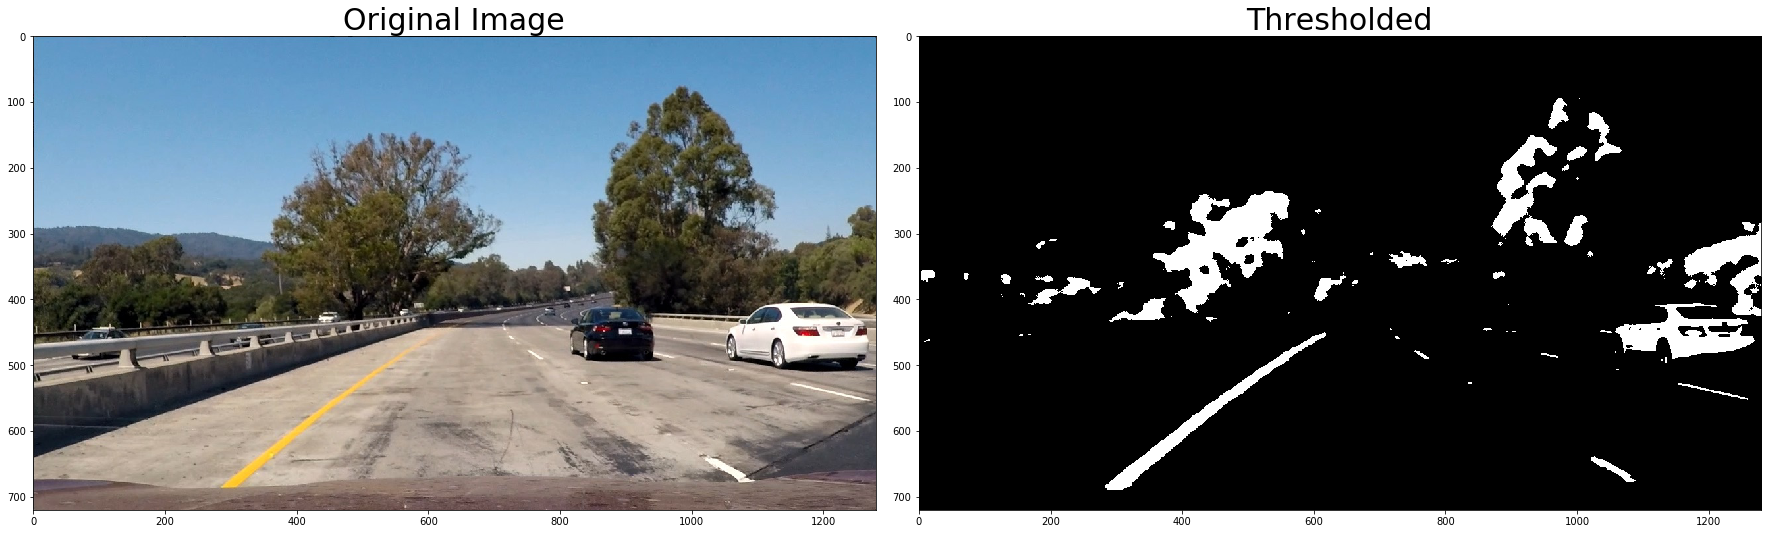

In [24]:
import image_utils

img = mpimg.imread('test_images/test1.jpg')

#src_points = np.array([[305, 710], [596, 459], [722, 459], [1220, 710]])
#dst_points = np.array([[305, 720], [305,  0], [ 1220, 0], [ 1220, 720]])

l_threshold = np.array([(213, 255), (203, 255)])
b_threshold = np.array([(145, 255), (196, 255)])
thresholded = image_utils.threshold_image(img, l_threshold, b_threshold, 0)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(img)
axes[0].set_title('Original Image', fontsize=30)
axes[1].imshow(thresholded, cmap='gray')
axes[1].set_title('Thresholded', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()




---

## 3. Transforming an image


The next step is to warp the image into a bird's-eye view.  The perspective matrix for performing this transformation is obtained by a call to the openCV function `getPerspectiveTransform()`.  To calculate this `getPerspectiveTransform()` needs points from the source image mapped to locations in the destination image.  In an attempt to handle differing image sizes I kept source points normalized between 0 and 1.  Four source points were mapped to destination points in the following manner:

- (bottom_left_x, bottom_left_y) in the source mapped to (bottom_right_x, height_of_image) in the destination
- (top_left_x, top_left_y) in the source mapped to (bottom_left_x, 0) in the destination
- (top_right_x, top_right_y) in the source mapped to (bottom_right_x, 0) in the destination
- (bottom_right_x, bottom_right_y) in the source mapped to (bottom_right_x, height_of_image) in the destination


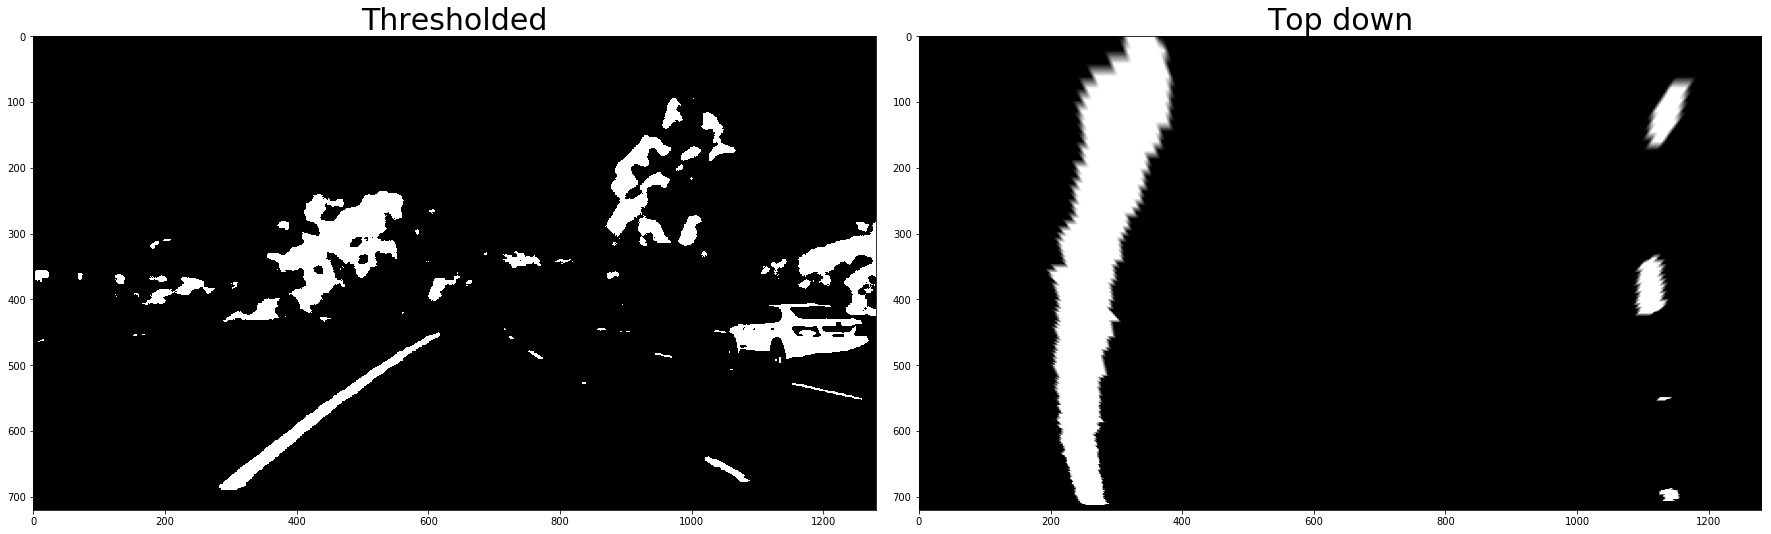

In [32]:
src_points = np.float32([(221, 710), (600, 451), (721, 451), (1177, 710)])
dst_points = np.float32([(221, 720), (221,  0), (1177, 0), (1177, 720)])
                       
warped = image_utils.warp_image(thresholded, src_points, dst_points)

f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(thresholded, cmap='gray')
axes[0].set_title('Thresholded', fontsize=30)
axes[1].imshow(warped, cmap='gray')
axes[1].set_title("Top down", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



Once the proper source and destintion points are mapped all it takes is a call to `cv2.warpPerspective()` to take the image to/from a top-down view.  The function `warp_image()` in the file `image_utils.py` (lines 58-71) takes care of both obtaining the perspective matrix and warping the image.

---
## 4. Recognizing lanes



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

canny_high           = 250
canny_low            = 235
min_line_length      = 13
max_line_gap         = 15
gaussian_kernel_size = 5
hough_threshold      = 1
hough_rho            = 1
theta                = np.pi/180


if not os.path.isdir('test_images_output'):
    os.makedirs('test_images_output')

for filename in images:
    avg_left_lines = []
    avg_right_lines = []
    
    #
    # Read in the image file
    #
    image = mpimg.imread('test_images/' + filename, 1)
    h, w, _ = image.shape

    #
    # convert to grayscale, blur with a gaussian blur, and
    # perform a canny edge detection
    #
    gray = grayscale(image)
    blurred = gaussian_blur(gray, gaussian_kernel_size)
    canny_edges = canny(blurred, canny_low, canny_high)

    #
    # mask a region of interest for the image based on the
    # normalized coordinates
    #
    norm_roi_points = [(0.1344, 0.9292), (0.4609, 0.625), (0.557, 0.625), (0.9375, 0.9292)]
    roi_points = []
    for x, y in norm_roi_points:
        roi_points.append((x*w, y*h))
    roi = np.array([roi_points], dtype=np.int32)
    masked = region_of_interest(canny_edges, roi)


    #
    # find hough lines and draw over the original image
    #
    roi_topY = int(norm_roi_points[1][1] * h)
    lanes = find_lanes(masked, hough_rho,  np.pi/180, hough_threshold, min_line_length, max_line_gap, roi_topY )
    out_image = weighted_img(lanes, image)
    out_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('test_images_output/' + filename, out_image)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def reset_averages():
    global avg_right_lines
    global avg_left_lines
    global frame
    avg_right_lines = []
    avg_left_lines = []
    frame = 0
    
def process_image(image):
    global frame    
    frame +=1
    
    canny_high           = 250
    canny_low            = 235
    min_line_length      = 100
    max_line_gap         = 160
    gaussian_kernel_size = 9
    hough_threshold      = 50
    hough_rho            = 1
    theta                = np.pi/180
    
    
    #
    # convert to grayscale, blur with a gaussian blur, and
    # perform a canny edge detection
    #
    gray = grayscale(image)
    equalized = cv2.equalizeHist(gray)
    blurred = gaussian_blur(equalized, gaussian_kernel_size)
    canny_edges = canny(blurred, canny_low, canny_high)

    #
    # mask a region of interest for the image based on the
    # normalized coordinates
    #
    norm_roi_points = [(0.1344, 0.9292), (0.4609, 0.625), (0.557, 0.625), (0.9375, 0.9292)]
    roi_points = []
    h, w, _ = image.shape
    for x, y in norm_roi_points:
        roi_points.append((x*w, y*h))
    roi = np.array([roi_points], dtype=np.int32)
    masked = region_of_interest(canny_edges, roi)


    #
    # find hough lines and draw over the original image
    #
    roi_topY = int(norm_roi_points[1][1] * h)
    lanes = find_lanes(masked, hough_rho,  np.pi/180, hough_threshold, min_line_length, max_line_gap, roi_topY )
    result = weighted_img(lanes, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
reset_averages()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
reset_averages()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,7)
clip3 = VideoFileClip('test_videos/challenge.mp4')
reset_averages()
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))